In [ ]:
!pip install torch_intermediate_layer_getter

Files already downloaded and verified
Files already downloaded and verified


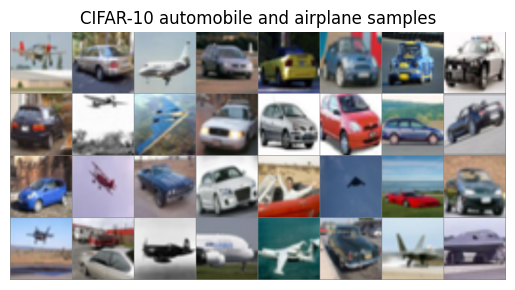

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models
import matplotlib.pyplot as plt
import numpy as np

# Load CIFAR-10 dataset and filter classes
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Select only airplane (class 0) and automobile (class 1)
train_idx = [i for i, label in enumerate(train_data.targets) if label in [0, 1]]
test_idx = [i for i, label in enumerate(test_data.targets) if label in [0, 1]]

train_data = Subset(train_data, train_idx)
test_data = Subset(test_data, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, pin_memory=True)


# Plot a few samples
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title("CIFAR-10 automobile and airplane samples")
    plt.show()

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))


In [ ]:
def layer_init(layer, std, bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


# Load pretrained EfficientNet model
model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            layer_init(nn.Linear(model.classifier[1].in_features, 256), std=0.01),
            nn.ReLU(),
            layer_init(nn.Linear(256, 2), std=0.01)
)


for param in model.classifier.parameters():
    param.requires_grad = True

for param in model.features[:4]:
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter

return_layers = {
    'features.0': 'conv1',
    'features.1': 'conv2',
    'features.2': 'conv3',
    'features.3': 'conv4',
    'features.8': 'fc9',
    }


def plot_features_maps(model, epoch, input, return_layers):
    model.eval()
    mid_getter = MidGetter(model, return_layers=return_layers, keep_output=True)
    layer_names = list(return_layers.values())

    with torch.no_grad():
        mid_outputs_model, model_output = mid_getter(input.unsqueeze(0))

    fig = plt.figure(figsize=(16, 3))
    fig.suptitle(f"epoch: {epoch}")

    a = fig.add_subplot(1, 7, 1)
    imgplot = plt.imshow(np.transpose(input.to('cpu'), (1, 2, 0)))
    a.axis("off")
    a.set_title("Input")

    for i in range(len(layer_names)):
        a = fig.add_subplot(1, 7, i+2)
        img = mid_outputs_model[layer_names[i]][0, 0].to('cpu').numpy()
        img += np.min(img)
        imgplot = plt.imshow(img/np.max(img))
        a.axis("off")
        a.set_title(layer_names[i])

    plt.show()



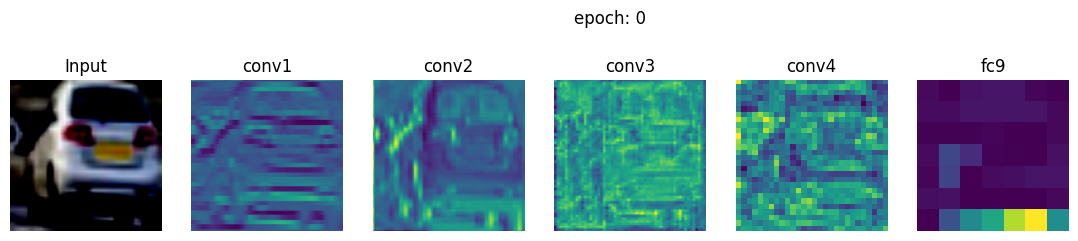

Epoch 1/5, Train Loss: 0.1654, Validation Loss: 0.1032, Train Accuracy: 0.9341, Validation Accuracy: 0.9615


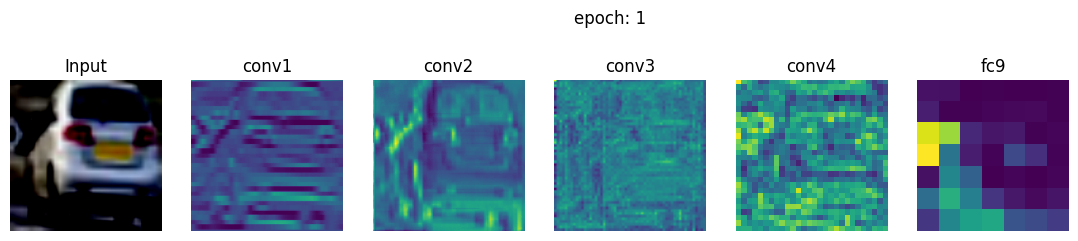

Epoch 2/5, Train Loss: 0.1439, Validation Loss: 0.0852, Train Accuracy: 0.9449, Validation Accuracy: 0.9695


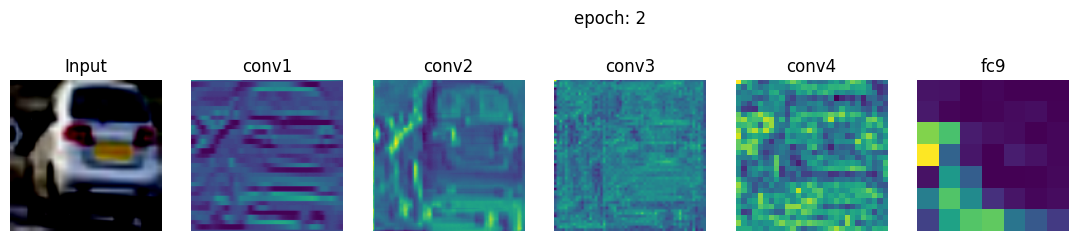

Epoch 3/5, Train Loss: 0.1355, Validation Loss: 0.0854, Train Accuracy: 0.9476, Validation Accuracy: 0.9675


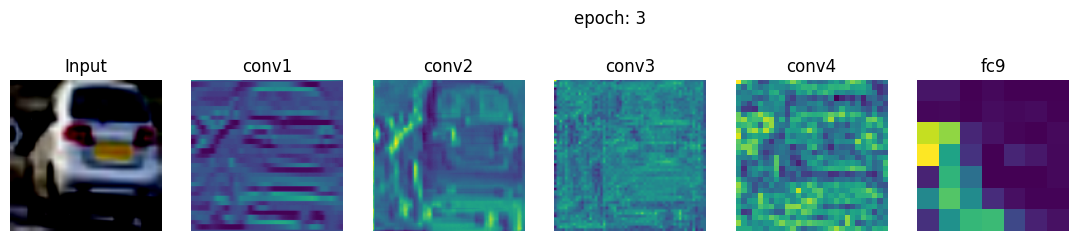

Epoch 4/5, Train Loss: 0.1145, Validation Loss: 0.0766, Train Accuracy: 0.9555, Validation Accuracy: 0.9690


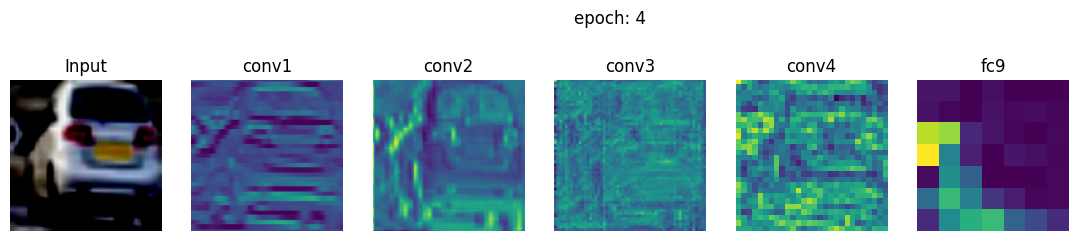

Epoch 5/5, Train Loss: 0.1113, Validation Loss: 0.0762, Train Accuracy: 0.9558, Validation Accuracy: 0.9740


In [ ]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss/len(train_loader), correct/total


def validate_model(model, val_loader, criterion, optimizer):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss/len(val_loader), correct/total



epochs = 5
history = np.zeros((epochs, 4))
inputs, labels = next(iter(train_loader))

for epoch in range(epochs):
    plot_features_maps(model, epoch, inputs[0].to(device), return_layers)
    train_loss, train_accuracy  = train_model(model, train_loader, criterion, optimizer)
    validation_loss, val_accuracy  = validate_model(model, test_loader, criterion, optimizer)
    history[epoch] = [train_loss, validation_loss, train_accuracy, val_accuracy]

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, " +
    f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


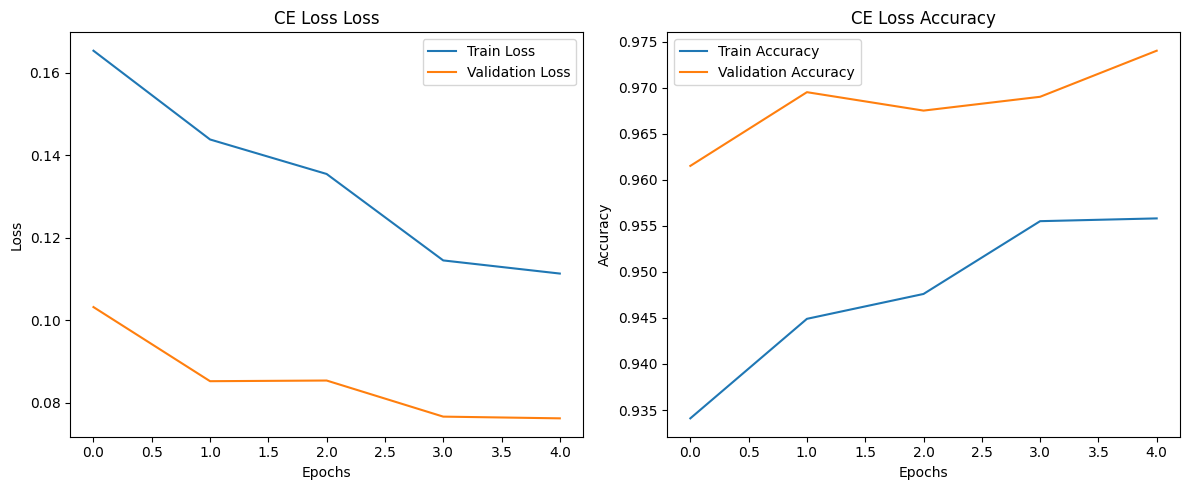

In [ ]:
# Plot training and validation metrics

def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history[:, 0], label="Train Loss")
    plt.plot(history[:, 1], label="Validation Loss")
    plt.title(model_name + " Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history[:, 2], label="Train Accuracy")
    plt.plot(history[:, 3], label="Validation Accuracy")
    plt.title(model_name + " Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_history(history, "CE Loss")

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()


In [ ]:
# Reference for Triplet Loss implementation: https://www.kaggle.com/code/hirotaka0122/triplet-loss-with-pytorch#Define-TripletLoss
from torch.utils.data import Dataset
import random
import pandas as pd


class CIFAR(Dataset):
    def __init__(self, data, train=True):
        self.is_train = train
        self.data = data

        self.idx0 = pd.DataFrame([i for i, (image, label)  in enumerate(self.data) if label==0]).values
        self.idx1 = pd.DataFrame([i for i, (image, label)  in enumerate(self.data) if label==1]).values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        anchor_img = self.data[item][0]
        anchor_label = self.data[item][1]

        item0 = self.data[random.choice(self.idx0[self.idx0 != item])][0]
        item1 = self.data[random.choice(self.idx1[self.idx1 != item])][0]

        if anchor_label==0:
            positive_img = item0
            negative_img = item1
        else:
            positive_img = item1
            negative_img = item0

        return anchor_img, positive_img, negative_img, anchor_label




train_ds = CIFAR(train_data, train=True)
train_loader_triplet = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)

test_ds = CIFAR(test_data, train=False)
test_loader_triplet = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
def train_model_triplet(model, train_loader, criterion, optimizer, network):
    model.train()
    running_loss = 0
    correct = 0
    total = 1e-6

    for anchor_img, positive_img, negative_img, anchor_label in train_loader:
        anchor_img, positive_img, negative_img, anchor_label = anchor_img.to(device), positive_img.to(device), negative_img.to(device), anchor_label.to(device)

        optimizer.zero_grad()

        anchor_out = model.features(anchor_img)

        loss = 0
        if network in ['conv', 'all'] :
            positive_out = model.features(positive_img)
            negative_out = model.features(negative_img)
            loss += criterion[0](anchor_out, positive_out, negative_out)

        if network in ['linear', 'all']:
            output = model(anchor_img)
            _, predicted = output.max(1)
            total += anchor_label.size(0)
            correct += predicted.eq(anchor_label).sum().item()
            loss += criterion[-1](output, anchor_label)


        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss/len(train_loader), correct/total


def validate_model_triplet(model, val_loader, criterion, optimizer, network):
    model.eval()
    running_loss = 0
    correct = 0
    total = 1e-6

    with torch.no_grad():
        for anchor_img, positive_img, negative_img, anchor_label in val_loader:
            anchor_img, positive_img, negative_img, anchor_label = anchor_img.to(device), positive_img.to(device), negative_img.to(device), anchor_label.to(device)

            anchor_out = model.features(anchor_img)

            loss = 0
            if network in ['conv', 'all'] :
                positive_out = model.features(positive_img)
                negative_out = model.features(negative_img)
                loss += criterion[0](anchor_out, positive_out, negative_out)

            if network in ['linear', 'all']:
                output = model(anchor_img)
                _, predicted = output.max(1)
                total += anchor_label.size(0)
                correct += predicted.eq(anchor_label).sum().item()
                loss += criterion[-1](output, anchor_label)

            running_loss += loss.item()

    return running_loss/len(val_loader), correct/total



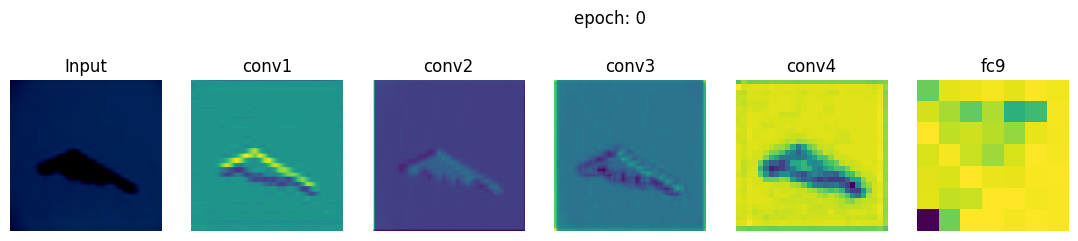

Epoch 1/5, Train Loss: 415.7937, Validation Loss: 329.2315, Train Accuracy: 0.0000, Validation Accuracy: 0.0000


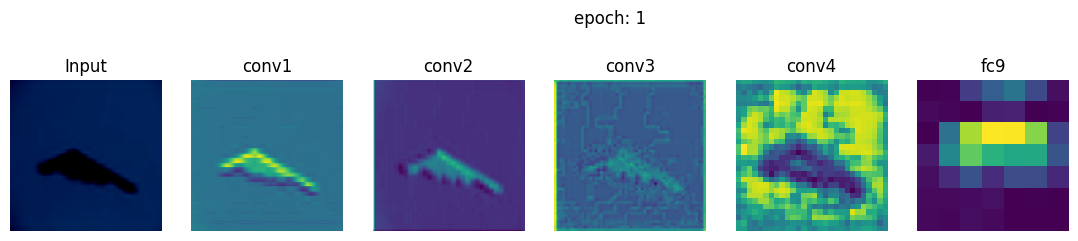

Epoch 2/5, Train Loss: 288.0479, Validation Loss: 122096.0652, Train Accuracy: 0.0000, Validation Accuracy: 0.0000


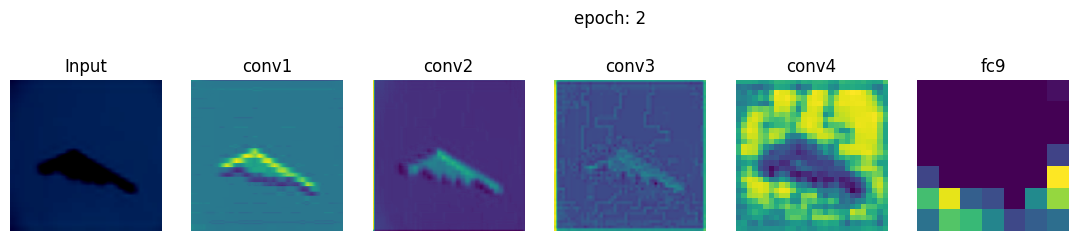

Epoch 3/5, Train Loss: 215.9060, Validation Loss: 139085.9129, Train Accuracy: 0.0000, Validation Accuracy: 0.0000


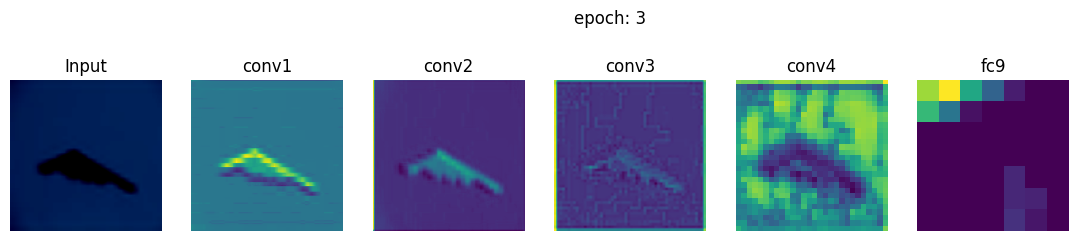

Epoch 4/5, Train Loss: 162.3044, Validation Loss: 119.5069, Train Accuracy: 0.0000, Validation Accuracy: 0.0000


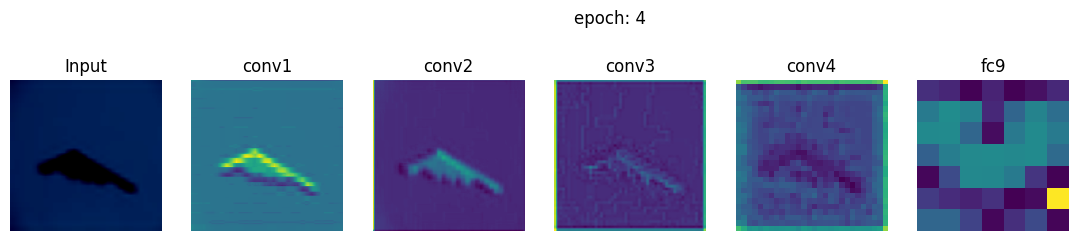

Epoch 5/5, Train Loss: 125.8937, Validation Loss: 90.3885, Train Accuracy: 0.0000, Validation Accuracy: 0.0000


In [ ]:
def layer_init(layer, std, bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

# Load pretrained EfficientNet model
model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')


model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            layer_init(nn.Linear(model.classifier[1].in_features, 256), std=0.01),
            nn.ReLU(),
            layer_init(nn.Linear(256, 2), std=0.01)
)

for param in model.features:
    param.requires_grad = False

for param in model.features[:4]:
    param.requires_grad = True


for param in model.classifier.parameters():
    param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


criterion = [TripletLoss()]
optimizer = torch.optim.Adam(model.features[:4].parameters(), lr=0.001)


epochs = 5
history = np.zeros((epochs, 4))
inputs, labels = next(iter(train_loader))

for epoch in range(epochs):
    plot_features_maps(model, epoch, inputs[0].to(device), return_layers)
    train_loss, train_accuracy  = train_model_triplet(model, train_loader_triplet, criterion, optimizer, 'conv')
    validation_loss, val_accuracy  = validate_model_triplet(model, test_loader_triplet, criterion, optimizer, 'conv')
    history[epoch] = [train_loss, validation_loss, train_accuracy, val_accuracy]

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, " +
    f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

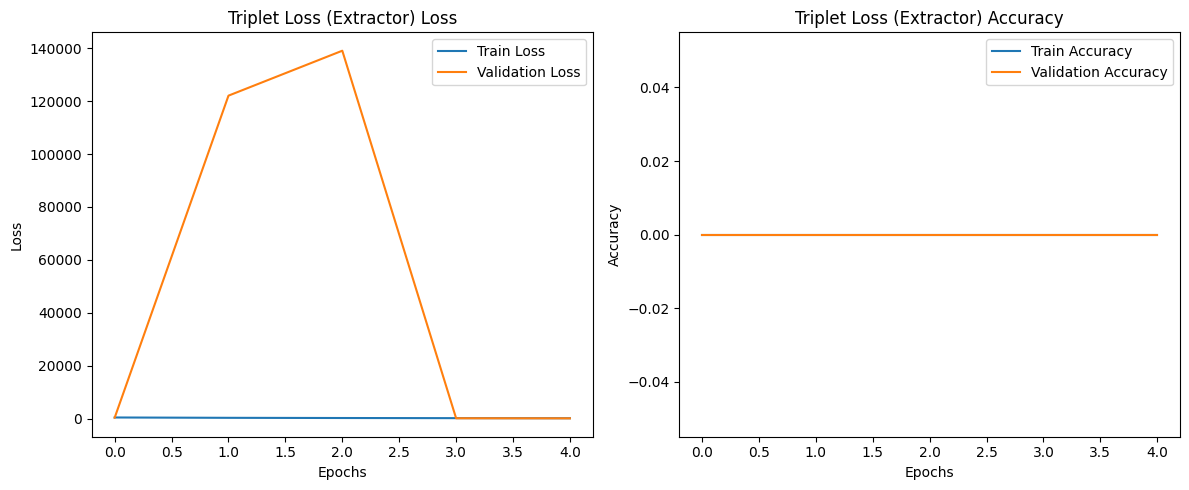

In [ ]:
plot_history(history, "Triplet Loss (Extractor)")

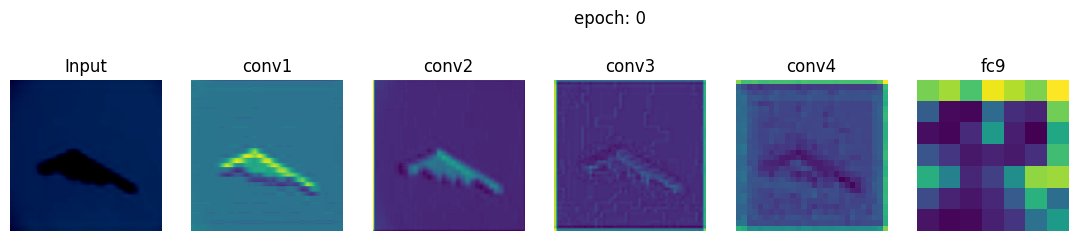

Epoch 1/15, Train Loss: 0.2650, Validation Loss: 0.2414, Train Accuracy: 0.8926, Validation Accuracy: 0.9055


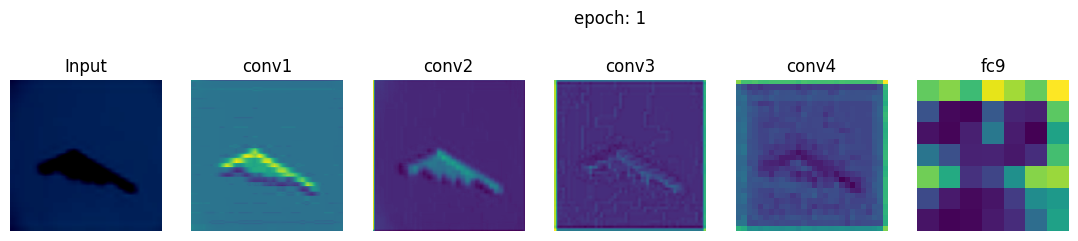

Epoch 2/15, Train Loss: 0.2591, Validation Loss: 0.2197, Train Accuracy: 0.8928, Validation Accuracy: 0.9115


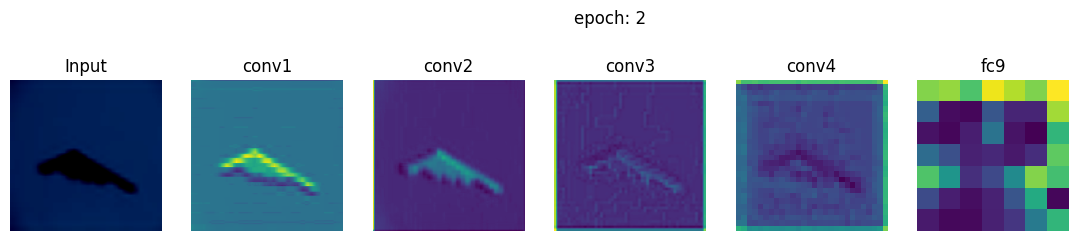

Epoch 3/15, Train Loss: 0.2505, Validation Loss: 0.2133, Train Accuracy: 0.8965, Validation Accuracy: 0.9085


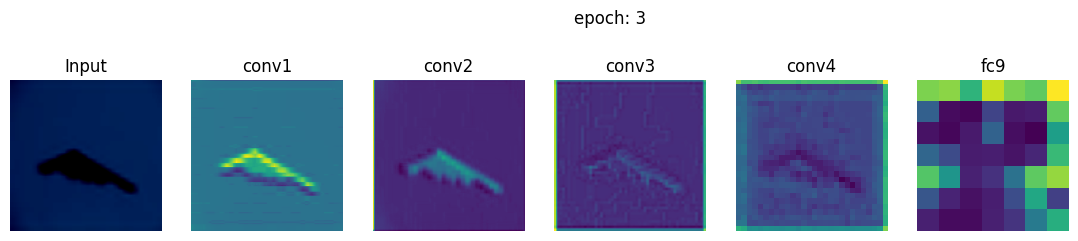

Epoch 4/15, Train Loss: 0.2534, Validation Loss: 0.2213, Train Accuracy: 0.8986, Validation Accuracy: 0.9125


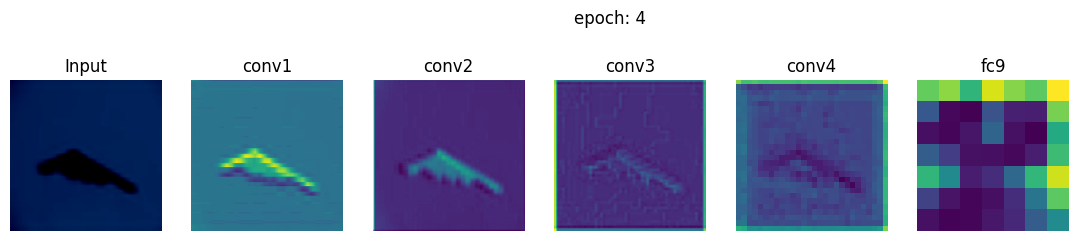

Epoch 5/15, Train Loss: 0.2443, Validation Loss: 0.2202, Train Accuracy: 0.8993, Validation Accuracy: 0.9090


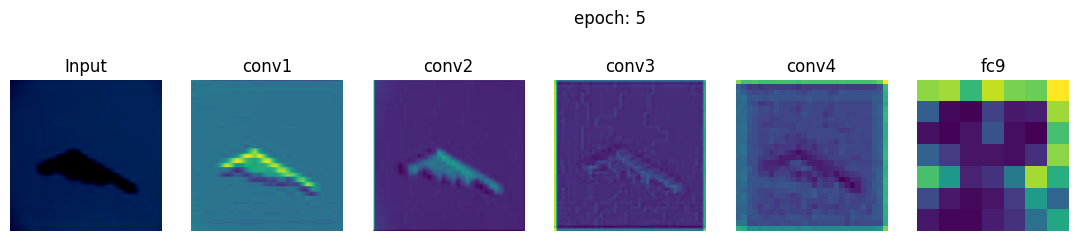

Epoch 6/15, Train Loss: 0.2332, Validation Loss: 0.2046, Train Accuracy: 0.9028, Validation Accuracy: 0.9135


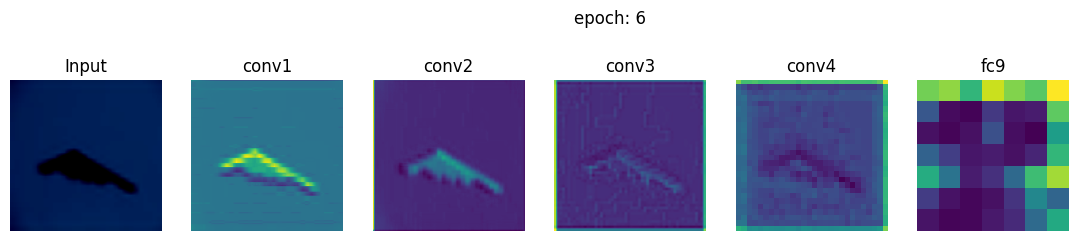

Epoch 7/15, Train Loss: 0.2419, Validation Loss: 0.2115, Train Accuracy: 0.9009, Validation Accuracy: 0.9200


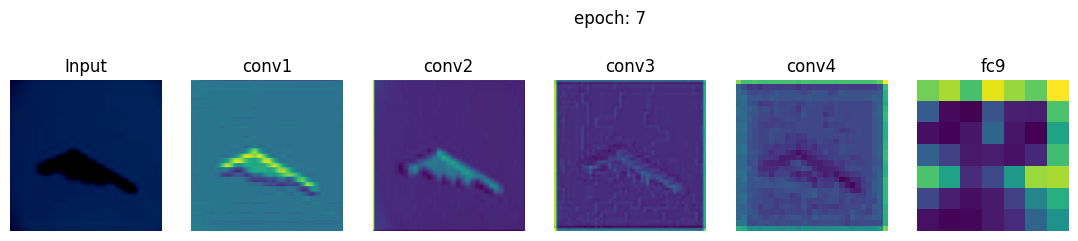

Epoch 8/15, Train Loss: 0.2373, Validation Loss: 0.2083, Train Accuracy: 0.9030, Validation Accuracy: 0.9100


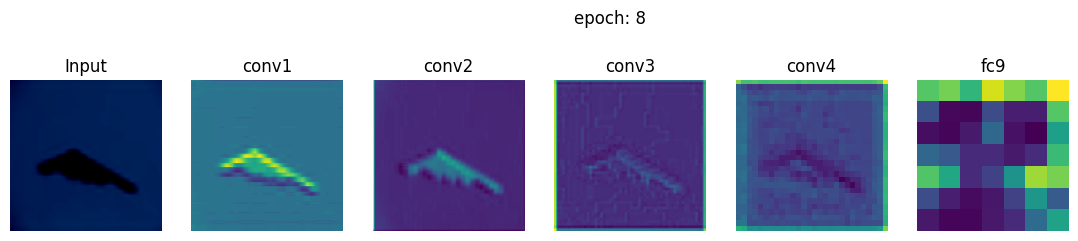

Epoch 9/15, Train Loss: 0.2391, Validation Loss: 0.2088, Train Accuracy: 0.9011, Validation Accuracy: 0.9170


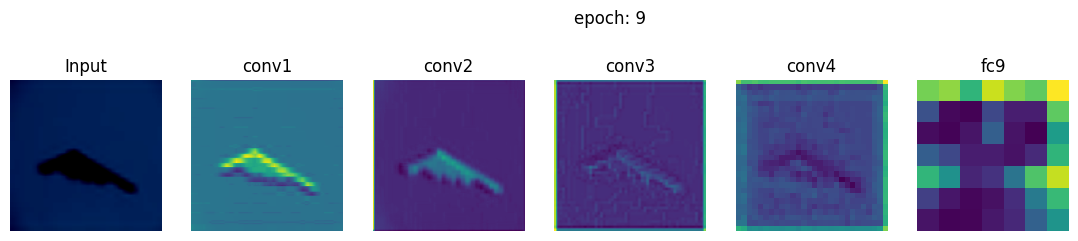

Epoch 10/15, Train Loss: 0.2398, Validation Loss: 0.1929, Train Accuracy: 0.9005, Validation Accuracy: 0.9205


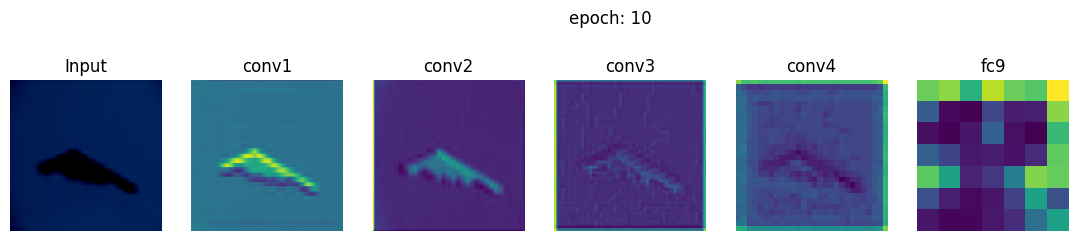

Epoch 11/15, Train Loss: 0.2309, Validation Loss: 0.1981, Train Accuracy: 0.9036, Validation Accuracy: 0.9125


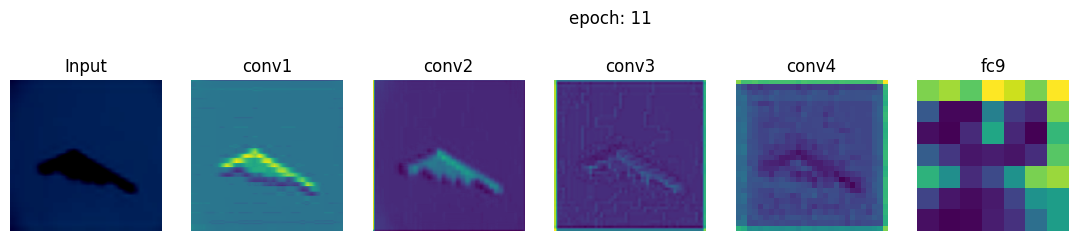

Epoch 12/15, Train Loss: 0.2328, Validation Loss: 0.2012, Train Accuracy: 0.9053, Validation Accuracy: 0.9190


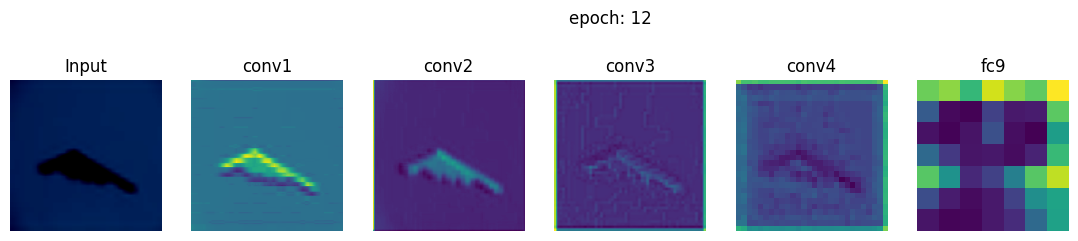

Epoch 13/15, Train Loss: 0.2293, Validation Loss: 0.2194, Train Accuracy: 0.9064, Validation Accuracy: 0.9190


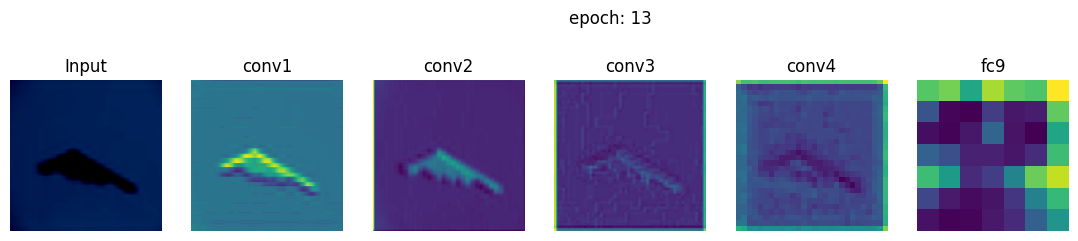

Epoch 14/15, Train Loss: 0.2348, Validation Loss: 0.1868, Train Accuracy: 0.9024, Validation Accuracy: 0.9275


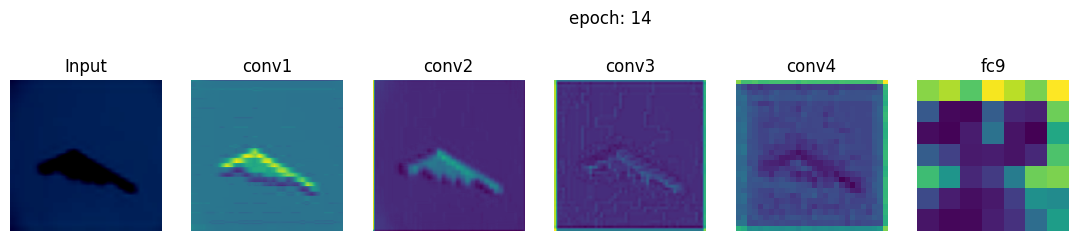

Epoch 15/15, Train Loss: 0.2248, Validation Loss: 0.1852, Train Accuracy: 0.9100, Validation Accuracy: 0.9225


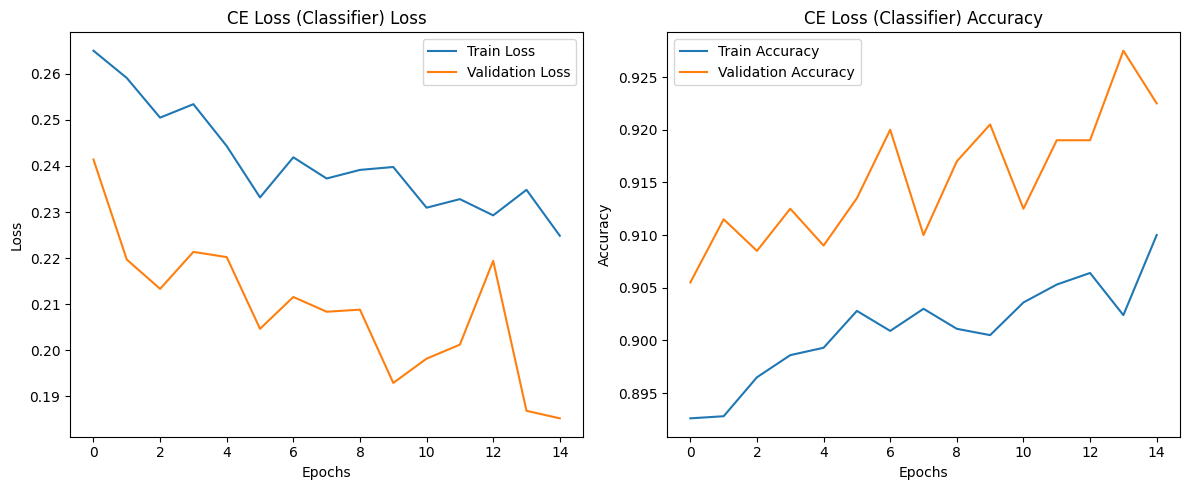

In [ ]:


for param in model.features.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)


epochs = 15
history = np.zeros((epochs, 4))
#inputs, labels = next(iter(train_loader))

for epoch in range(epochs):
    plot_features_maps(model, epoch, inputs[0].to(device), return_layers)
    train_loss, train_accuracy  = train_model(model, train_loader, criterion, optimizer)
    validation_loss, val_accuracy  = validate_model(model, test_loader, criterion, optimizer)
    history[epoch] = [train_loss, validation_loss, train_accuracy, val_accuracy]

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, " +
    f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


plot_history(history, "CE Loss (Classifier)")

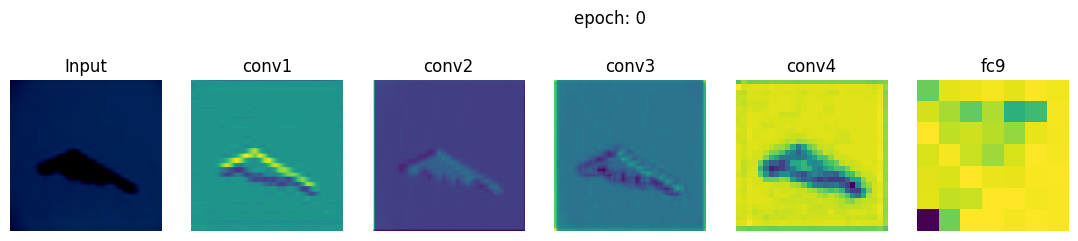

Epoch 1/5, Train Loss: 579.1843, Validation Loss: 581.9042, Train Accuracy: 0.9225, Validation Accuracy: 0.9635


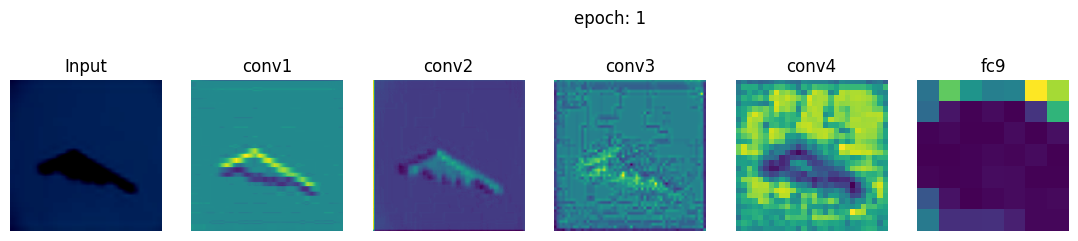

Epoch 2/5, Train Loss: 579.9457, Validation Loss: 575.4629, Train Accuracy: 0.9445, Validation Accuracy: 0.9675


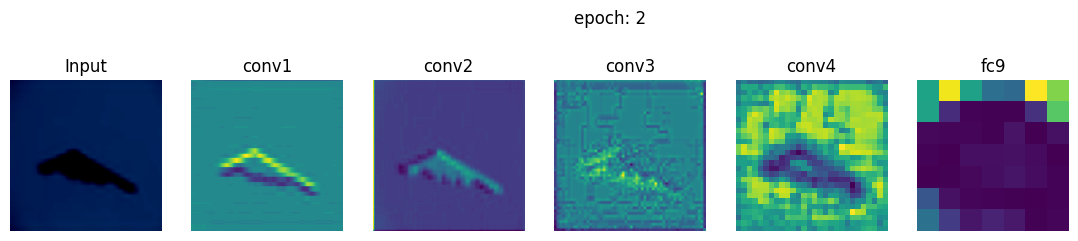

Epoch 3/5, Train Loss: 579.9025, Validation Loss: 589.0363, Train Accuracy: 0.9503, Validation Accuracy: 0.9680


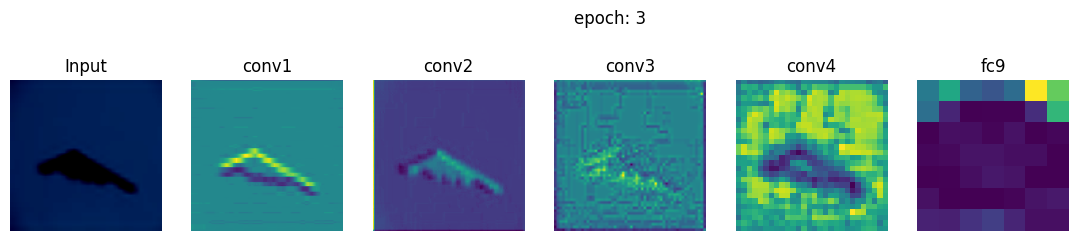

Epoch 4/5, Train Loss: 575.7789, Validation Loss: 585.3373, Train Accuracy: 0.9512, Validation Accuracy: 0.9650


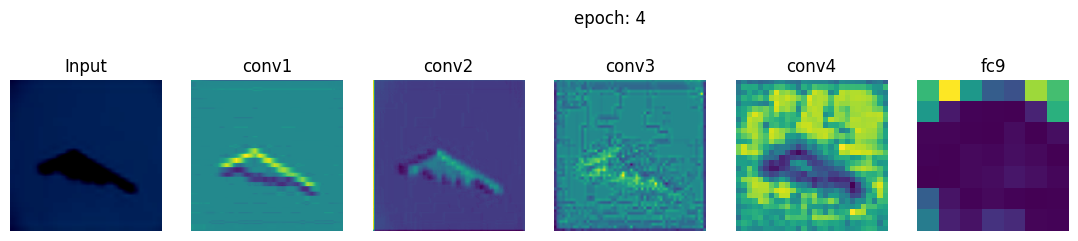

Epoch 5/5, Train Loss: 579.7169, Validation Loss: 576.4151, Train Accuracy: 0.9541, Validation Accuracy: 0.9680


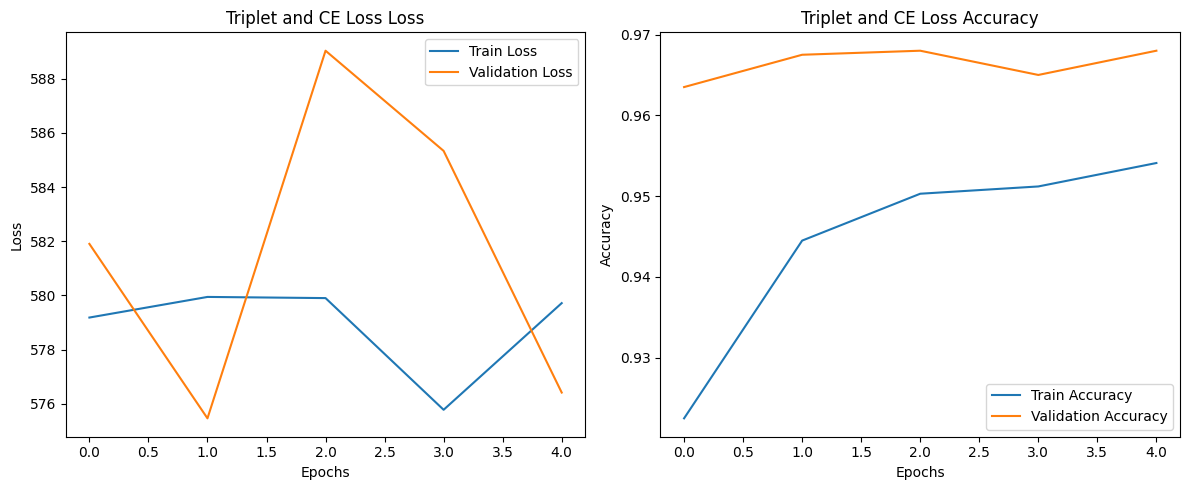

In [ ]:
# Load pretrained EfficientNet model
model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            layer_init(nn.Linear(model.classifier[1].in_features, 256), std=0.01),
            nn.ReLU(),
            layer_init(nn.Linear(256, 2), std=0.01)
)

for param in model.features[:4]:
    param.requires_grad = True


for param in model.classifier.parameters():
    param.requires_grad = True

model.to(device)

criterion = [TripletLoss(), nn.CrossEntropyLoss()]
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
history = np.zeros((epochs, 4))

for epoch in range(epochs):
    plot_features_maps(model, epoch, inputs[0].to(device), return_layers)
    train_loss, train_accuracy  = train_model_triplet(model, train_loader_triplet, criterion, optimizer, 'all')
    validation_loss, val_accuracy  = validate_model_triplet(model, test_loader_triplet, criterion, optimizer, 'all')
    history[epoch] = [train_loss, validation_loss, train_accuracy, val_accuracy]

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, " +
    f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


plot_history(history, "Triplet and CE Loss")